## A Hands-on Workshop series in Machine Learning
### Session 7: Fine tuning the models
#### Instructor: Aashita Kesarwani

What are some of the common challenges encountered in training the neural networks?
* Overfitting
* Underfitting
* Vanishing gradient problem
* Dead neurons

How would you diagnose whether your network is suffering from one or more of the above challenges?

What are some of the ways to address each of the above problems?

### Overfitting and Underfitting

How to address underfitting?

Increase complexity:
* Add more layers and/or nodes in each layer
* Add more non-linearity by using activation functions in all layers and try out a different activation function
* Increase the number of epochs for training
* Increase the number of features, if possible, either by gathering more data or creating new features out of the existing ones

How to address overfitting?

Reduce complexity:
- Reduce the number of features 
    - Discard some features
    - Dimensionality reduction techniques such as PCA, LDA, etc.
- Simplify the model (by tuning hyperparameters)
- Reduce the number of epochs for training
- Regularization (L1, L2 and Dropout), if applicable
- Add more training examples, if possible, for example image data augmentation  
<img src="https://i.stack.imgur.com/rpqa6.jpg" width="450" height="600" />


### Image Data Augmentation:
It is expensive to label the images to use them for training the neural networks. There are data augmentation methods to create artifical images from the available ones that are already labeled. Some of the ways to generate new images from existing ones are:
* Flipping - horizontal and also vertical, in some case
* Translation - horizontal, vertical or mix of both
* Rotation
* Zooming in or out (in other words, rescaling the images)
* Cropping
* Changing contrasts

![](https://nanonets.com/blog/content/images/2018/11/1_C8hNiOqur4OJyEZmC7OnzQ.png)

Data augmentation methods can be easily implemented using [`ImageDataGenerator`](https://keras.io/preprocessing/image/) in Keras.

In [8]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
import numpy as np
 
(X_train, y_train), (X_valid, y_valid) = cifar10.load_data()
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
 
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_valid = np_utils.to_categorical(y_valid,num_classes)
 
# Input image dimensions
input_shape = X_train[0].shape

    
# Build the CNN
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2))) # outputs a matrix with half width and height
model.add(Dropout(0.2)) # Dropout layers prevent overfitting, helping the model generalize

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='sigmoid', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
 
model.summary()

batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

In [ ]:
# Training 
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0], epochs=1,
                    verbose=1,validation_data=(X_valid,y_valid))
 
# Testing
scores = model.evaluate(X_valid, y_valid, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

Epoch 1/1
   34/50000 [..............................] - ETA: 2:42:37 - loss: 1.7907 - acc: 0.3341

## Dimensionality reduction:

Many a times, our real-world dataset contains too many features. Using all the features can lead to a very complex model that would be prone to overfitting if we do not have the sufficient number of training examples in our dataset. A simple way to address this is to discard features.

Q: How do we know which features to discard? 

Sometimes, the features that do not seem to have much impact on the target variable individually might prove to be very useful in conjunction with other features. If we do not want to risk losing information by discarding features, we use dimensionality reduction techniques. The most commonly used one is Principal Component Analysis (PCA).


### Principal Component Analysis (PCA):

If we have 100 features, we can think of having 100 dimensional feature space with an axis for each feature. In essence, we transform our 100 old features into 100 new ones, ranked in the order of importance. To accomplish this, we rotate the axis of the features to capture the most variability of data in our first principal axis and then try to capture as much from the remaining variability as possible in the second axis and so on. We ultimately keep only as many features as we want, discarding the least important ones and thus, reducing the dimension.

![](https://www.researchgate.net/profile/Nicholas_Czarnek/publication/320410861/figure/fig7/AS:551041819447302@1508390015760/Example-application-of-principal-component-analysis-to-simple-synthetic-data-The-black.png)

In the figure, we have transformed the two dimensional data using PCA. If we want to reduce it to one-dimension, we will simply discard the principal component 2, having captured most of the variability in the principal component 1.  The downside of PCA is that the new features are no longer as interpretable, and unlike the old features, we cannot explain what they exactly represent. The upside is that we have captured as much variability as possible in fewer features.

PCA is useful in machine learning for purposes other than dimensionality reduction. The linear models rely on the assumption that the features are independent of each other. In general, features from real-world datasets are not entirely independent, but if we transform them using PCA, the new features become independent of each other. This makes new features much more suited to build linear models such as linear/ridge/lasso regression and logistic classifier. Other uses of this technique involves data compression and visualization of data (when the number of features are reduced to 2 or 3).

The steps in PCA are outlined below. It would be Okay to skip this and revisit later after learning/revising linear algebra, especially eigen-values and eigen-vectors.
* First create a matrix for which each row is an observation and each column is a feature (similar to our dataframe, but all columns must be numerical values). 
* Center each column around zero by substracting the respective mean from each column.  
* Compute the covariance matrix
* Find the eigen values and the eigen vectors for the covariance matrix. 
* Normalize each of the eigenvector to become unit vector.

We pick the largest eigen value and the corresponding eigen vector becomes our first principal component (or first new axis). The eigen vector corresponding to the second largest eigen value becomes our second component and so on.

Note: We must always normalize the data before PCA. 

The following is the implementation of PCA using [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

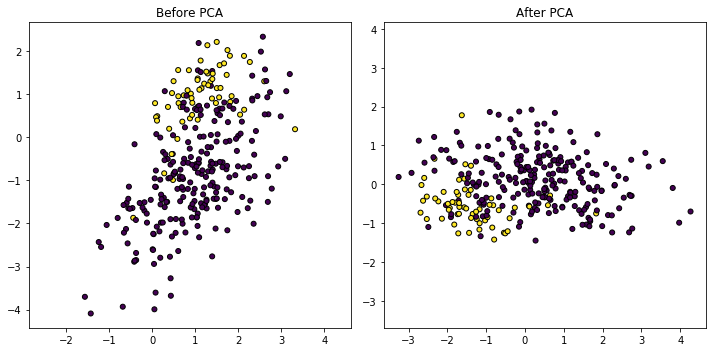

In [12]:
# First we create a dataset for demonstration
from sklearn.datasets import make_classification
X1, y1 = make_classification(
    n_samples=300, n_features=2, 
    n_redundant=0, n_informative=2, 
    n_classes=2, n_clusters_per_class=1, 
    class_sep=1, weights=[0.8, 0.2],
    flip_y=0.05, random_state=0 
)

# We fit the PCA transformer and transform our dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X1)
X_pca = pca.transform(X1)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Before PCA")
plt.axis("equal")
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=y1,
            s=25, edgecolor='k');
plt.subplot(1, 2, 2)
plt.title("After PCA")
plt.axis("equal")
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y1,
            s=25, edgecolor='k');
plt.tight_layout()

Another dimensionality reduction technique is [Linear Discriminant Analysis (LDA)](https://sebastianraschka.com/Articles/2014_python_lda.html). LDA is similar to PCA except that it tries to maximize the class separation instead of data variance.
<img src="https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png" width="500" height="500"/>

### Transfer learning

Suppose I have trained a network to detect whether there is a pedestrian in an image or not. And I have trained another neural network to detect patients at risk of a certain type of cancer. 

Now, I want to build a network to detect where there is a biker in an image. Unfortunately, I have a relatively smaller dataset of labeled images to train a network that is complex enough to detect bikers and I am short on the resources to get more labeled data, and computing power that will be required to train the deeper network. 

What if I start with the pre-trained neural network that does a good job of detecting the pedestrians and fine tune it using the labeled images for detecting bikers? 

If I only had the neural network trained for detecting at risk patients, could I use that somehow?

Transfer learning is using a pre-trained model as a starting point and fine tuning it using the given dataset to perform a desired task. It is much more commonly used for image classification. This is because there is certain amount of learning involved that is common to most images. Another area where transfer learning is effectively used is datasets involving texts and making use of natural language processing tools. This will be covered in the series in next semester.


Thumb rules for 4 common scenarios taken from the notes of [Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/):

> 1. New dataset is small and similar to original dataset. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.
2. New dataset is large and similar to the original dataset. Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.
3. New dataset is small but very different from the original dataset. Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.
4. New dataset is large and very different from the original dataset. Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

There are certain large labeled datasets such as [ImageNet](http://www.image-net.org/) that are used to test the models for image detection. Researchers have developed certain advanced architectures that are tested to have worked very well on the above mentioned datasets. Model pre-trained with these architectures are easy-to-implement in Keras, as shown below.


### Keep learning:

* Workout the derivation of the equations for the weight updates in the backpropagation process in a few neural networks with simple architecture. 
* Code the training process for a neural netword using numpy from scratch. Define functions for:
    * weight and bias initialization
    * cost function
    * forward propagation
    * backward propagation
    * predicting final output
    You can also add more functions such as regularization, dropout, etc.
* Activation functions
* Optimizers: We have studied how gradient descent is used for optimizing the cost by updating the weights. This optimization forms the basis of the back-propagation process. There are more advanced optimizers, that in certain situations, give better performance. Some of them are:
    * Adam
    * RMSprop
    * AdaGrad
    
   
#### [Google Colab](https://research.google.com/colaboratory/faq.html)

#### [Kaggle](https://www.kaggle.com/)


### Acknowledgements:
The credits for the images used above are as follows:

- Image 1: https://stats.stackexchange.com/questions/292283/general-question-regarding-over-fitting-vs-complexity-of-models?rq=1
- Image 2: https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/
- Image 3: https://www.researchgate.net/figure/Example-application-of-principal-component-analysis-to-simple-synthetic-data-The-black_fig7_320410861
- Image 4: https://sebastianraschka.com/Articles/2014_python_lda.html